In [239]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from astropy.io import fits,ascii
import pandas as pd
import cmasher as cmr
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import pingouin

In [242]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_1Re.csv")
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
galfit = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
ssp = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv('/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv')
master = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_master_source_catalogue.csv",skiprows=16)
prospect = prospect[prospect['MAGPIID'].isin(sample["MAGPIID"])]
galfit = galfit[galfit["MAGPIID"].isin(sample["MAGPIID"])]
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
ssp = ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]
master = master[master['MAGPIID'].isin(sample["MAGPIID"])]

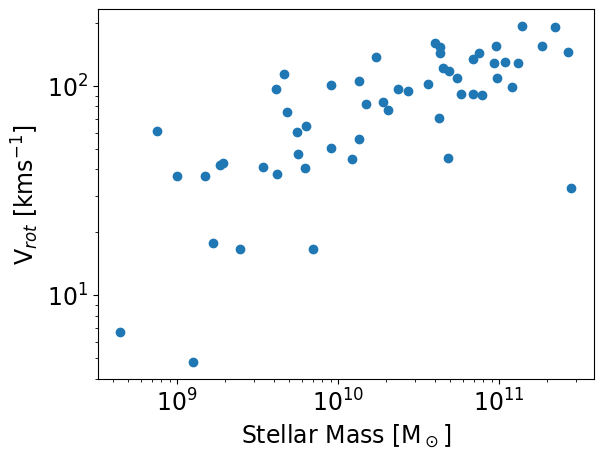

In [246]:
vrot = sample["V_rot_g"].to_numpy()
q = master["axrat_it"].to_numpy()
inc = np.arccos(np.sqrt(q**2 - 0.2**2)/(1-0.2**2))
vrot = vrot/(2*np.sin(inc))
mass = prospect["StellarMass_median"].to_numpy()

fig,ax =plt.subplots()
ax.scatter(mass,vrot)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax.set_ylabel(r"V$_{rot}$ [kms$^{-1}$]")
plt.show()